In [3]:
import sys, os
from glob import glob
import re
import time
from datetime import datetime 
import pydot 
# import graphviz

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

import tensorflow as tf
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import seaborn as sb
import psutil

# Directly importing from tf.keras for convenience
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Dropout, MaxPool1D, AveragePooling1D, MaxPool2D,GlobalMaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling2D, concatenate, Activation, Dropout, Lambda, Multiply, Add, BatchNormalization

from scipy.special import softmax
from sklearn.model_selection import train_test_split

print("--------- Sys Info ---------")
print(sys.version)
print(" ")
print("--------- Utility Info ---------")
print("Cpu Usage: " + str(psutil.cpu_percent()) + "%")
print("Memory Usage:")
print(psutil.virtual_memory())
print(" ")
print("--------- Package Versions ---------")
print("Tensorflow Version: " + tf.__version__)
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Matplotlib Version: " + mpl.__version__)
print(" ")
print("--------- Local Hardware ---------")
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

--------- Sys Info ---------
3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
 
--------- Utility Info ---------
Cpu Usage: 3.7%
Memory Usage:
svmem(total=137302384640, available=124688769024, percent=9.2, used=12613615616, free=124688769024)
 
--------- Package Versions ---------
Tensorflow Version: 2.1.0
Numpy Version: 1.18.1
Pandas Version: 1.0.1
Matplotlib Version: 3.1.3
 
--------- Local Hardware ---------


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8826456436565999296,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9023611863
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 8318217216733050294
 physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:0a:00.0, compute capability: 7.5",
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 9023611863
 locality {
   bus_id: 1
   links {
     link {
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 207373149815624125
 physical_device_desc: "device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:41:00.0, compute capability: 7.5"]

# WaveNet

The goal here is to produce a generative model which can be used for prediction of time series data. The model below represents an implementation of a Convolutional WaveNetwork by Van den Oord et al. This current model is a testing/developmental prototype, and requires a 1-d input array of scalar values. Hence, it is set up only for single dimensional time-series data. With a small amount of work, it can be made ready for an input array of high dimensional vectors, such as words or audio waveforms. 

![](./diagrams/Architecture.jpg)

![](./diagrams/residual_block.png)

In [34]:
'''
Convolutional Wavenet Model

'''

class WaveNet:
    def __init__(self,
                dilation_size,  
                dilation_stages,
                input_dim,
                num_hidden_kernels,
                hidden_kernel_size,
                num_output_kernels,
                output_kernel_size,
                output_dim,
                activation_function,
                output_activation,
                callbacks, 
                learning_rate, 
                momentum, 
                cost_function, 
                metrics, 
                optim):
        
        self.dilation_size = dilation_size
        self.lookback_length = dilation_size**dilation_stages
        
        self.input_dim = input_dim 
        self.num_hidden_kernels = num_hidden_kernels
        self.hidden_kernel_size = hidden_kernel_size
        self.activation_function = activation_function
        
        self.num_output_kernels = num_output_kernels
        self.output_kernel_size = output_kernel_size
        self.output_activation = output_activation
        self.output_dim = output_dim
        
        self.callbacks = callbacks 
        self.learning_rate = learning_rate 
        self.momentum = momentum 
        self.cost_function = cost_function
        self.metrics = metrics
        self.optim = optim
        
        self.model = None
        self.model_history = None
            
    def __prepare_input_layers(self):
      output = []
      for i in range(int(self.lookback_length)):
        output.append(Input(shape=(None, self.input_dim)))
      return output

    def __concatenate_previous_layers(self, layers, i, j):
        concat_layers = []
        for k in range(self.dilation_size):
            concat_layers.append(layers[i][j*self.dilation_size + k])
        return concatenate(concat_layers)

    def __define_model(self):
        
        dilation_stages = (np.log(self.lookback_length) / np.log(self.dilation_size)).astype('int64')

        layers = [self.__prepare_input_layers()]
        skip_connections = []
        
        for i in range(dilation_stages):
          layer_arr = []
          for j in range(int(self.lookback_length / self.dilation_size**(i+1))):          
            if (i >= 0) and (i < (dilation_stages - 1)):         
              x = self.__concatenate_previous_layers(layers, i, j)
              x = BatchNormalization()(x)
              x = Conv1D(self.num_hidden_kernels, 
                         self.hidden_kernel_size, 
                         padding='same', 
                         activation=self.activation_function, 
                         kernel_regularizer=l2(0.01))(x)
              x_filter = BatchNormalization()(x)
              x_filter = Conv1D(self.num_hidden_kernels, 
                                self.hidden_kernel_size, 
                                padding='same', 
                                kernel_regularizer=l2(0.01))(x_filter) 
              x_gate = BatchNormalization()(x)
              x_gate = Conv1D(self.num_hidden_kernels, 
                              self.hidden_kernel_size, 
                              padding='same',
                              kernel_regularizer=l2(0.01))(x_gate)
              z = Multiply()([Activation('tanh')(x_filter), 
                              Activation('sigmoid')(x_gate)])
              z = Conv1D(self.num_hidden_kernels, 
                         self.hidden_kernel_size, 
                         padding='same', 
                         activation=self.activation_function, 
                         kernel_regularizer=l2(0.01))(z) 
              skip_connections.append(z)   
              x = Add()([x, z])
              layer_arr.append(x)
            
            else:
              output = Add()(skip_connections)
              output = BatchNormalization()(output)
              output = Activation(self.activation_function)(output)
              output = BatchNormalization()(output)
              output = Conv1D(self.num_output_kernels, 
                              self.output_kernel_size, 
                              padding='same', 
                              activation=self.activation_function, 
                              kernel_regularizer=l2(0.01))(output) 
              output = BatchNormalization()(output)
              output = Dense(self.output_dim, 
                             activation=output_activation, 
                             kernel_regularizer=l2(0.01))(output)
              layer_arr.append(output)
            
          layers.append(layer_arr)

        self.model = Model(layers[0], 
                           layers[-1])
    
    def __compile_model(self, nesterov=True):

        self.model.compile(optimizer=optim(learning_rate=self.learning_rate, 
                                      momentum=self.momentum, 
                                      nesterov=nesterov), 
                      loss=self.cost_function, 
                      metrics=self.metrics)

    
    def build_model(self):
        self.__define_model()
        self.__compile_model()
        
    def return_model(self):
        return self.model
    
    def __sequence_data_window(self, arr, start):
        end = start + self.lookback_length

        if ((end - start) % self.dilation_size != 0 or (end - start) < 0):
            raise Exception('Need window size which is a factor of dilation')

        output = [np.array([arr[i]]).reshape(1, 1,-1) for i in range(start, end)]
        return output

    def train_model(self, data):
        model_History = None

        for epoch in range(1):
            for i in range(0, len(data)-(self.lookback_length)):

                if(len(data)<self.lookback_length):
                    raise Exception('Window Size must be lower than sequence length.')

                
                train_sequence = self.__sequence_data_window(data, i)

                print('-----------------------------')
                print(train_sequence)
                print(i)
                print(i+self.lookback_length)
                print(np.array([data[i+self.lookback_length]]))

                self.model_history = self.model.fit(train_sequence, np.array([data[i+self.lookback_length]]), epochs=1, batch_size = 1, callbacks=self.callbacks, verbose=True)

                print(self.model.predict(train_sequence))         
                    
    def predict(self, data, time_steps):
        
        pred_data = data 
        while len(pred_data) < self.lookback_length:
            new_arr = [data[0]]
            new_arr += pred_data
            pred_data = new_arr
            

        for i in range(time_steps):
            current_pred_data = self.__sequence_data_window(pred_data, i)
            print(current_pred_data)
            prediction = self.model.predict(current_pred_data)
            pred_data.append(prediction)
            
            print(prediction)
            print(type(prediction))
            
def create_training_sequence(d):
    scaler = StandardScaler()

    sample = []

    power = np.random.normal(1, 1, 1)[0]
    base1 = np.random.normal(1, 0.5, 1)[0]
    base2 = 0
    for j in range(1, d+1):
      base1 += (j*2)
      base2 += base1**(power**2)
      sample.append(base1 + base2)

    sample = np.array(sample)
    sample -= np.mean(sample)
    sample /= np.std(sample)
    return np.array(sample)

def create_training_sequence_labeled_vector(d):
    scaler = StandardScaler()

    sample = []

    power = np.random.normal(1, 1, 1)[0]
    base1 = np.random.normal(1, 0.5, 1)[0]
    base2 = 0
    for j in range(1, d+1):
      base1 += (j*2)
      base2 += base1**(power**2)
      sample.append([power*j, base1**2, base2**0.5, base1 + base2])

    sample = np.array(sample)
    sample -= np.mean(sample)
    sample /= np.std(sample)
    return np.array(sample)


dilation_size = 2
dilation_stages = 4

input_dim = 1
num_hidden_kernels = 32
hidden_kernel_size = 1
num_output_kernels = 32
output_kernel_size = 1
output_dim = 1
activation_function = 'relu'
output_activation = 'linear'


earlyStoppingCallback = EarlyStopping(monitor='loss', patience=3)
callbacks = [earlyStoppingCallback]

learning_rate = 0.099
momentum = 0.7 

cost_function = 'MSE'
metrics = ['mse']
optim = SGD

wavenet = WaveNet(dilation_size,
                dilation_stages,
                input_dim,
                num_hidden_kernels,
                hidden_kernel_size,
                num_output_kernels,
                output_kernel_size,
                output_dim,
                activation_function,
                output_activation,
                callbacks, 
                learning_rate, 
                momentum, 
                cost_function, 
                metrics, 
                optim)


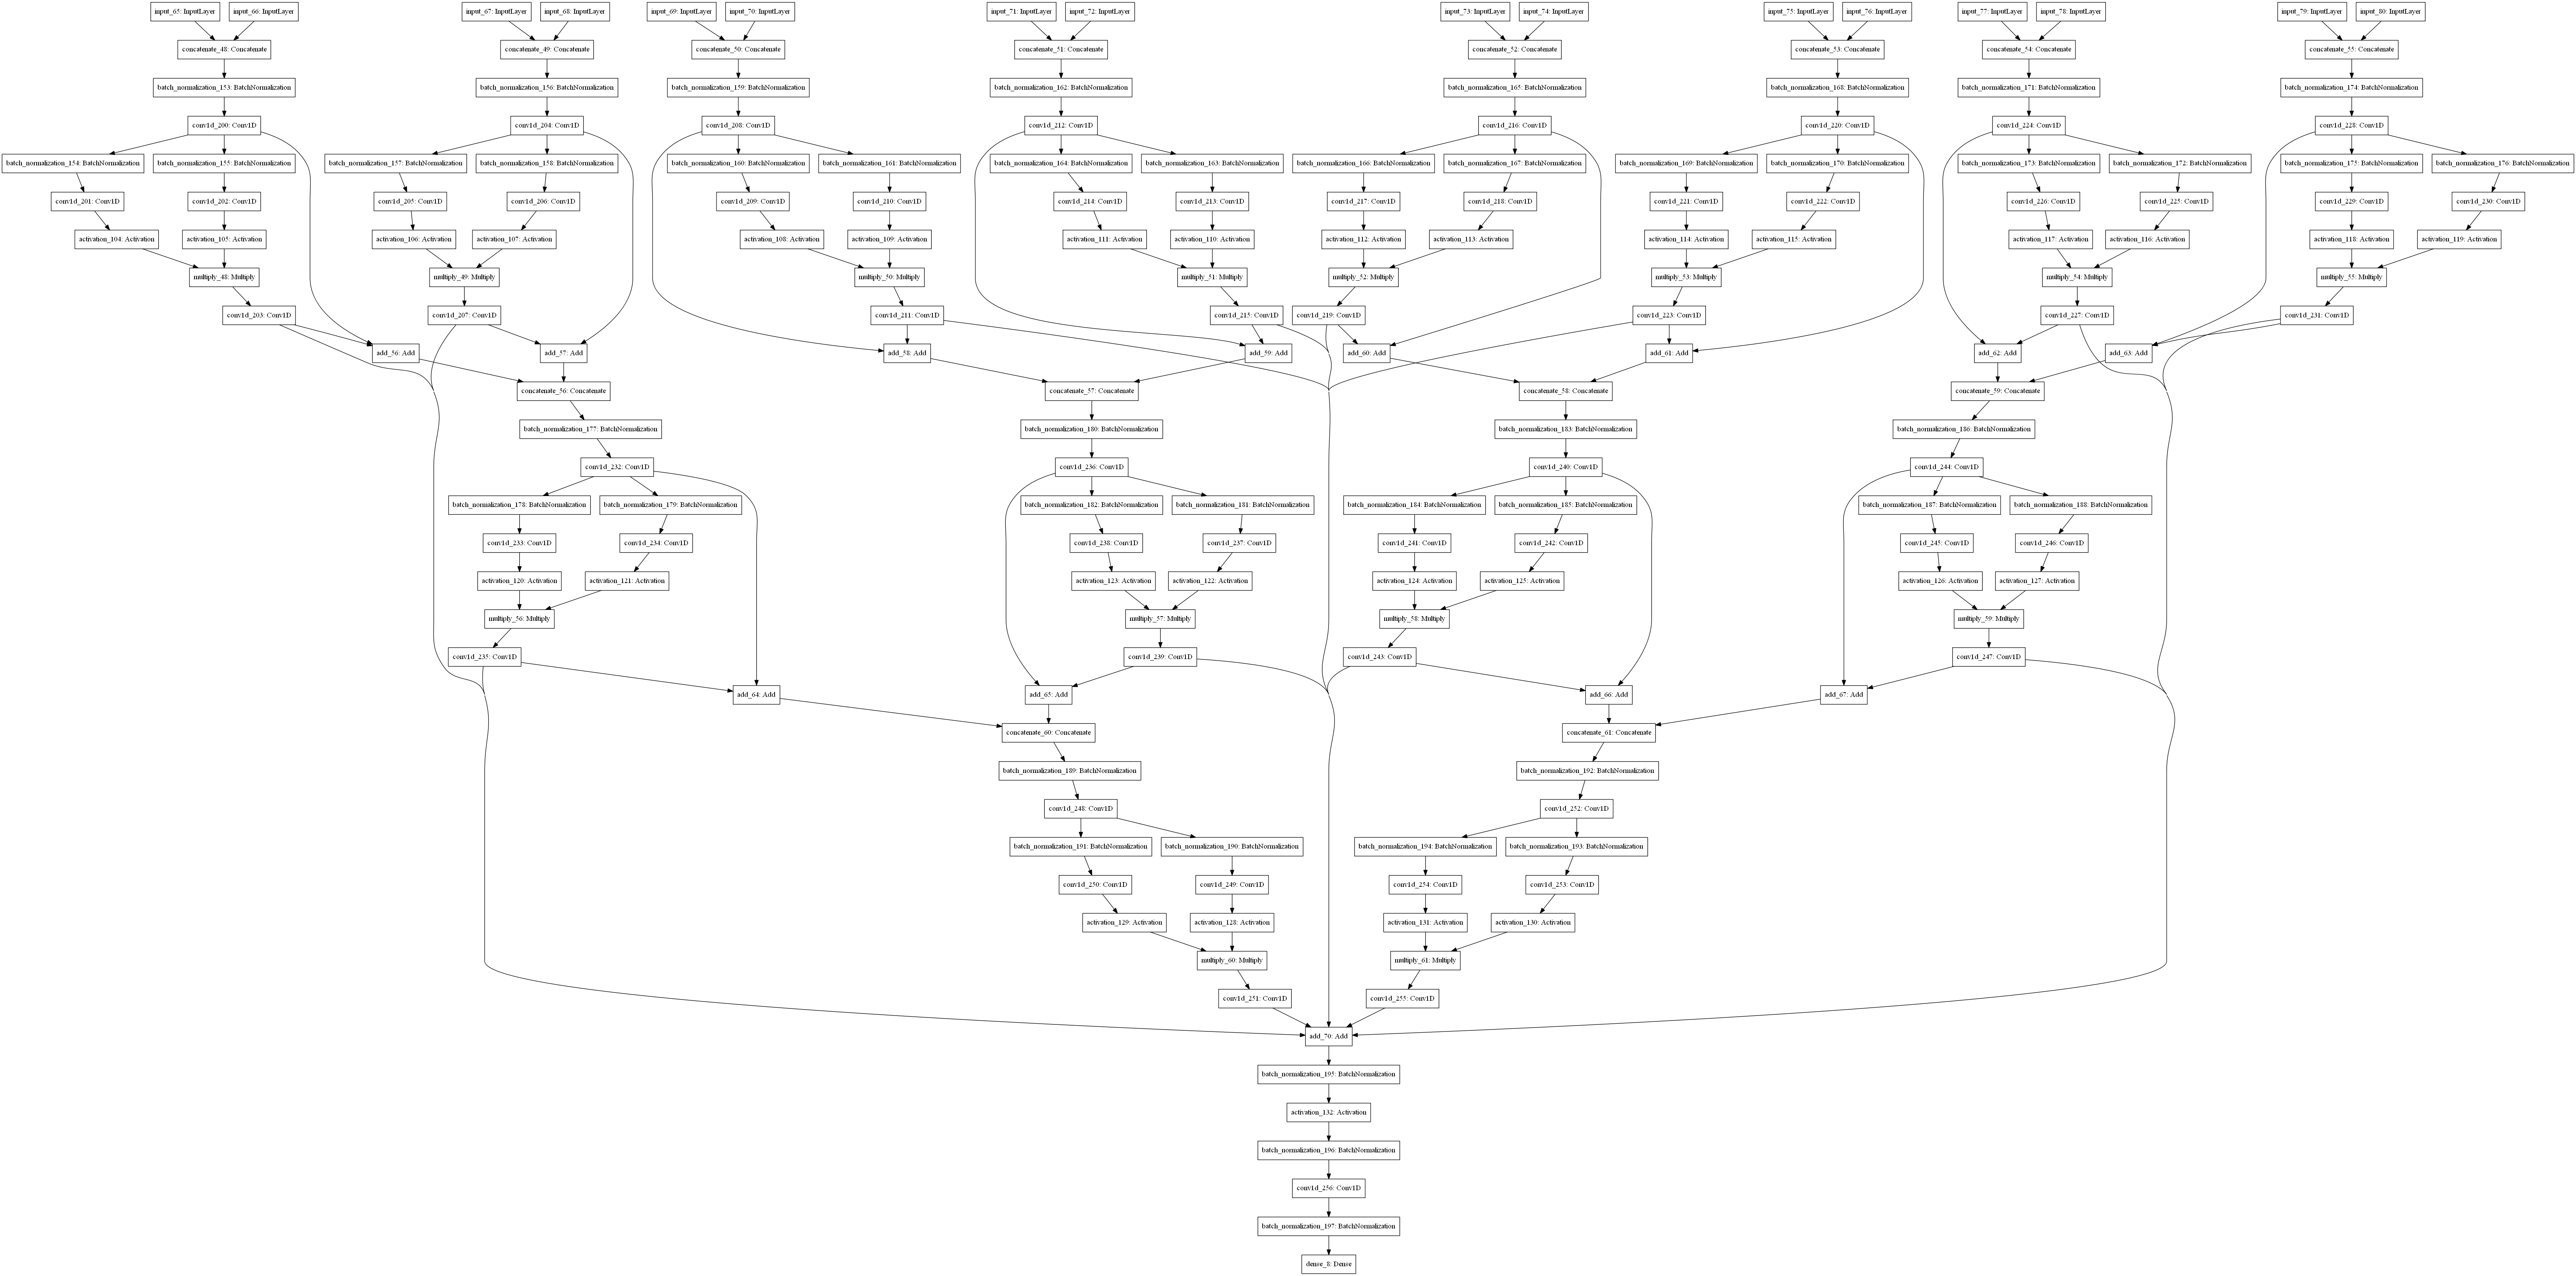

In [35]:
wavenet.build_model()

plot_model(wavenet.return_model())


In [36]:
wavenet.return_model().summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_65 (InputLayer)           [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
input_66 (InputLayer)           [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
input_67 (InputLayer)           [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
input_68 (InputLayer)           [(None, None, 1)]    0                                            
____________________________________________________________________________________________

In [37]:
test_data = create_training_sequence(128)

In [38]:

model_History = wavenet.train_model(test_data)

-----------------------------
[array([[[-1.13215851]]]), array([[[-1.13115625]]]), array([[[-1.12975314]]]), array([[[-1.12794924]]]), array([[[-1.12574458]]]), array([[[-1.12313919]]]), array([[[-1.12013309]]]), array([[[-1.1167263]]]), array([[[-1.11291882]]]), array([[[-1.10871067]]]), array([[[-1.10410185]]]), array([[[-1.09909237]]]), array([[[-1.09368224]]]), array([[[-1.08787145]]]), array([[[-1.08166001]]]), array([[[-1.07504792]]])]
0
16
[-1.0680352]
Train on 1 samples
1/1 [==============================] - 12s 12s/sample - loss: 17.8216 - mse: 1.1407
[[[-0.5508341]]]
-----------------------------
[array([[[-1.13115625]]]), array([[[-1.12975314]]]), array([[[-1.12794924]]]), array([[[-1.12574458]]]), array([[[-1.12313919]]]), array([[[-1.12013309]]]), array([[[-1.1167263]]]), array([[[-1.11291882]]]), array([[[-1.10871067]]]), array([[[-1.10410185]]]), array([[[-1.09909237]]]), array([[[-1.09368224]]]), array([[[-1.08787145]]]), array([[[-1.08166001]]]), array([[[-1.07504792]]

[-0.38218366 -0.38218366 -0.38218366 -0.38218366 -0.38218366 -0.38218365
 -0.38218353 -0.3821828  -0.38217916 -0.38216348 -0.38210427 -0.38190359
 -0.38128342 -0.37951309 -0.37479657 -0.36296895 -0.33485486 -0.27113883
 -0.13277479  0.15634762  0.73979275  1.88041454  4.04659437]
<class 'numpy.ndarray'>
(23,)


[array([[-0.38218366]]), array([[-0.38218365]]), array([[-0.38218353]]), array([[-0.3821828]]), array([[-0.38217916]]), array([[-0.38216348]]), array([[-0.38210427]]), array([[-0.38190359]])]
<class 'list'>
<class 'numpy.ndarray'>
(1, 1)
